In [1]:
%run ../../bin/imports.ipynb
from xgboost import XGBClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Fully clonal mixtures

In [3]:
cutoff = 0.5
BAF_cutoff = 0.02
R_cutoff = 0.98

In [4]:
training_columns = ['purity', 'ploidy', 'Sequenza_Loss',
                    'minMedCoverage','baf_median', 'percCov', 'totalCoverage_median']

output_ffn = '/rnd/users/rpyke/data/00-DASH/manuscript_data_v2/training.xgboost_model.2021_05_10.p'
model = pickle.load(open(output_ffn, 'rb'))

##### Sensitivity with fully clonal mixtures

In [5]:
cell_lines = ['CRL-5922', 'CRL-5911', 'CRL-2314']

In [6]:
tmp_dfs = []
for cell_line in cell_lines:
    tmp_df = pd.read_csv('/rnd/users/rpyke/data/00-DASH/manuscript_data_v2/validation.cell_line_dash_output.{0}.csv'.format(cell_line),
                                         index_col=0)
    print(cell_line, list(tmp_df.columns))
    tmp_dfs.append(tmp_df)
    
artificial_purities_raw_df = pd.concat(tmp_dfs)

CRL-5922 ['Purity', 'R1', 'R2', 'BAF', 'Sequenza_Loss', 'Alternate_Loss', 'Dash_Loss', 'Ploidy', 'consistency_of_coverage', 'prediction_probability', 'secondary_check', 'total_coverage', 'Gene', 'Sample', 'ind']
CRL-5911 ['Purity', 'R1', 'R2', 'BAF', 'Sequenza_Loss', 'Alternate_Loss', 'Dash_Loss', 'Ploidy', 'consistency_of_coverage', 'prediction_probability', 'secondary_check', 'total_coverage', 'Gene', 'Sample', 'ind']
CRL-2314 ['Purity', 'R1', 'R2', 'BAF', 'Sequenza_Loss', 'Alternate_Loss', 'Dash_Loss', 'Ploidy', 'consistency_of_coverage', 'prediction_probability', 'secondary_check', 'total_coverage', 'Gene', 'Sample', 'ind']


In [7]:
len(artificial_purities_raw_df)

2912

In [8]:
artificial_purities_raw_df.head()

,Purity,R1,R2,BAF,Sequenza_Loss,Alternate_Loss,Dash_Loss,Ploidy,consistency_of_coverage,prediction_probability,secondary_check,total_coverage,Gene,Sample,ind
0,1.00,0.000052,1.654309,0.505381,True,True,True,5,0.847826,0.994991,False,1.654356,B,CRL-5922_tumor_p100_rep1,0
1,1.00,0.000051,1.786976,0.496225,True,True,True,5,0.869565,0.995448,False,1.787059,C,CRL-5922_tumor_p100_rep1,1
2,0.77,0.099897,1.578995,0.445050,True,True,True,5,0.847826,0.800964,False,1.644918,B,CRL-5922_tumor_p90_rep1,2
3,0.77,0.098027,1.689733,0.444421,True,True,True,5,0.869565,0.995448,False,1.764339,C,CRL-5922_tumor_p90_rep1,3
4,0.62,0.187041,1.512448,0.390142,True,True,True,5,0.847826,0.800964,False,1.722242,B,CRL-5922_tumor_p81_rep1,4


In [9]:

artificial_purities_raw_df['LOH'] = True
artificial_purities_raw_df['real_purity'] = artificial_purities_raw_df['Sample'].str.split('_p').str[1].str.split('_').str[0].astype(int)
artificial_purities_raw_df['Dash_Loss_Prob'] = artificial_purities_raw_df['prediction_probability']
#artificial_purities_raw_df['Dash_Loss_Ext'] = artificial_purities_raw_df.prediction_probability <= cutoff

# Adding in another check
artificial_purities_raw_df['R_min'] = artificial_purities_raw_df[['R1', 'R2']].min(axis=1)
artificial_purities_raw_df['Check_FP'] = (artificial_purities_raw_df.BAF > BAF_cutoff) \
                                         &(artificial_purities_raw_df.R_min < R_cutoff) #\
                                         #&(artificial_purities_raw_df.Sequenza_Loss == False)

artificial_purities_raw_df['Dash_Loss_Ext'] = (artificial_purities_raw_df.prediction_probability > cutoff) \
                                                &(artificial_purities_raw_df.Check_FP)


In [10]:
artificial_purities_raw_df.head()

,Purity,R1,R2,BAF,Sequenza_Loss,Alternate_Loss,Dash_Loss,Ploidy,consistency_of_coverage,prediction_probability,...,total_coverage,Gene,Sample,ind,LOH,real_purity,Dash_Loss_Prob,R_min,Check_FP,Dash_Loss_Ext
0,1.00,0.000052,1.654309,0.505381,True,True,True,5,0.847826,0.994991,...,1.654356,B,CRL-5922_tumor_p100_rep1,0,True,100,0.994991,0.000052,True,True
1,1.00,0.000051,1.786976,0.496225,True,True,True,5,0.869565,0.995448,...,1.787059,C,CRL-5922_tumor_p100_rep1,1,True,100,0.995448,0.000051,True,True
2,0.77,0.099897,1.578995,0.445050,True,True,True,5,0.847826,0.800964,...,1.644918,B,CRL-5922_tumor_p90_rep1,2,True,90,0.800964,0.099897,True,True
3,0.77,0.098027,1.689733,0.444421,True,True,True,5,0.869565,0.995448,...,1.764339,C,CRL-5922_tumor_p90_rep1,3,True,90,0.995448,0.098027,True,True
4,0.62,0.187041,1.512448,0.390142,True,True,True,5,0.847826,0.800964,...,1.722242,B,CRL-5922_tumor_p81_rep1,4,True,81,0.800964,0.187041,True,True


In [11]:
artificial_purities_raw_df.groupby('real_purity').Dash_Loss_Ext.mean()

real_purity
0      0.014286
1      0.000000
2      0.125000
3      0.228571
4      0.342857
5      0.514286
6      0.600000
7      0.657143
8      0.700000
9      0.742857
10     0.742857
12     0.701493
14     0.714286
15     0.714286
16     0.714286
18     0.714286
20     0.714286
21     0.701493
24     0.880597
25     0.971429
27     1.000000
28     1.000000
30     1.000000
32     1.000000
35     1.000000
36     1.000000
40     1.000000
42     1.000000
45     0.985714
48     1.000000
49     1.000000
50     1.000000
54     1.000000
56     1.000000
60     1.000000
63     1.000000
64     1.000000
70     1.000000
72     1.000000
80     1.000000
81     1.000000
90     1.000000
100    1.000000
Name: Dash_Loss_Ext, dtype: float64

In [12]:
artificial_purities_raw_df[(artificial_purities_raw_df.real_purity == 45)
                           &(artificial_purities_raw_df.Dash_Loss == False)]

,Purity,R1,R2,BAF,Sequenza_Loss,Alternate_Loss,Dash_Loss,Ploidy,consistency_of_coverage,prediction_probability,...,total_coverage,Gene,Sample,ind,LOH,real_purity,Dash_Loss_Prob,R_min,Check_FP,Dash_Loss_Ext
407,0.25,1.744594,0.549207,0.256825,True,True,False,5,0.913043,0.430399,...,2.275675,C,CRL-2314_tumor_p45_rep4,407,True,45,0.430399,0.549207,True,False


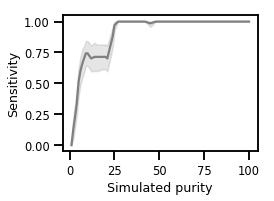

In [13]:
plt.figure(figsize=(3.5, 2.5))
sns.set_context('talk', font_scale=0.7)

sns.lineplot(x='real_purity', y='Dash_Loss_Ext', 
             data=artificial_purities_raw_df[artificial_purities_raw_df.real_purity != 0], color='grey')

plt.xlabel('Simulated purity')
plt.ylabel('Sensitivity')
#plt.title('DASH')
plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/DASH.sensitivity.purity.line.all_cell_lines.pdf', bbox_inches='tight')

In [14]:
# Saving source data
panel_name = 'supp_figure_9a'
artificial_purities_raw_df[artificial_purities_raw_df.real_purity != 0][['real_purity', 'Dash_Loss_Ext', 'LOH']].sort_values('real_purity').to_excel('/rnd/users/rpyke/data/00-DASH/manuscript_source_data/{0}.xlsx'.format(panel_name),
                                 index=None)

##### Sensitivity across variable clonalities

In [15]:
# Make new column: adjusted purity (to reflect subclonality)
all_small_artificial_dfs = []
purities = list(range(10, 110, 10))
clonalities = list(range(10, 110, 10))
for purity in purities:
    for clonality in clonalities:
        actual_purity = round(int(purity*clonality)/100)
        tmp_df = artificial_purities_raw_df[artificial_purities_raw_df.real_purity == actual_purity]
        # Adjust values to the purity/ploidy that would be called by sequenza!
        sequenza_purity = artificial_purities_raw_df[artificial_purities_raw_df.real_purity == purity].Purity.mean()
        tmp_df['adjusted_purity'] = sequenza_purity
        sequenza_ploidy = artificial_purities_raw_df[artificial_purities_raw_df.real_purity == purity].Ploidy.mean()
        tmp_df['adjusted_ploidy'] = sequenza_ploidy
        all_small_artificial_dfs.append(tmp_df)
        print(purity, clonality, actual_purity, sequenza_purity)

artificial_purities_df = pd.concat(all_small_artificial_dfs)

artificial_purities_df['old_purity'] = artificial_purities_df['Purity']
# This line adjusts the purity input to the model based on clonality
artificial_purities_df['purity'] = artificial_purities_df['adjusted_purity']
artificial_purities_df['ploidy'] = artificial_purities_df['adjusted_ploidy']

#artificial_purities_df['ploidy'] = artificial_purities_df['Ploidy']
artificial_purities_df['sequenza_minor'] = [0 if x == True else 1 for x in artificial_purities_df['Sequenza_Loss']]
artificial_purities_df['minMedCoverage'] = artificial_purities_df[['R1','R2']].min(axis=1)
artificial_purities_df['baf_median'] = artificial_purities_df['BAF']
artificial_purities_df['percCov'] = artificial_purities_df['consistency_of_coverage']
artificial_purities_df['totalCoverage_median'] = artificial_purities_df['total_coverage']
artificial_purities_df['Sequenza_Loss'] = ~artificial_purities_df['sequenza_minor'].astype(bool)

10 10 1 0.10299999999999997
10 20 2 0.10299999999999997
10 30 3 0.10299999999999997
10 40 4 0.10299999999999997
10 50 5 0.10299999999999997
10 60 6 0.10299999999999997
10 70 7 0.10299999999999997
10 80 8 0.10299999999999997
10 90 9 0.10299999999999997
10 100 10 0.10299999999999997
20 10 2 0.1251428571428571
20 20 4 0.1251428571428571
20 30 6 0.1251428571428571
20 40 8 0.1251428571428571
20 50 10 0.1251428571428571
20 60 12 0.1251428571428571
20 70 14 0.1251428571428571
20 80 16 0.1251428571428571
20 90 18 0.1251428571428571
20 100 20 0.1251428571428571
30 10 3 0.15800000000000003
30 20 6 0.15800000000000003
30 30 9 0.15800000000000003
30 40 12 0.15800000000000003
30 50 15 0.15800000000000003
30 60 18 0.15800000000000003
30 70 21 0.15800000000000003
30 80 24 0.15800000000000003
30 90 27 0.15800000000000003
30 100 30 0.15800000000000003
40 10 4 0.21600000000000005
40 20 8 0.21600000000000005
40 30 12 0.21600000000000005
40 40 16 0.21600000000000005
40 50 20 0.21600000000000005
40 60 24 0

In [16]:
artificial_purities_df.columns

Index(['Purity', 'R1', 'R2', 'BAF', 'Sequenza_Loss', 'Alternate_Loss',
       'Dash_Loss', 'Ploidy', 'consistency_of_coverage',
       'prediction_probability', 'secondary_check', 'total_coverage', 'Gene',
       'Sample', 'ind', 'LOH', 'real_purity', 'Dash_Loss_Prob', 'R_min',
       'Check_FP', 'Dash_Loss_Ext', 'adjusted_purity', 'adjusted_ploidy',
       'old_purity', 'purity', 'ploidy', 'sequenza_minor', 'minMedCoverage',
       'baf_median', 'percCov', 'totalCoverage_median'],
      dtype='object')

In [17]:
X_test = artificial_purities_df[training_columns]
y_test = artificial_purities_df[['LOH']]

predictions = model.predict(X_test)
prediction_probs = model.predict_proba(X_test)[:, 1]

In [18]:
# Adding second check
artificial_purities_df['Check_FP'] = (artificial_purities_df.baf_median > BAF_cutoff) \
                                         &(artificial_purities_df.minMedCoverage < R_cutoff)

artificial_purities_df['Dash_Loss_Ext'] = (artificial_purities_df.prediction_probability > cutoff) \
                                                &(artificial_purities_df.Check_FP)


In [19]:
# Adjusting for cutoff
lenient = []
for x, check in zip(prediction_probs, artificial_purities_df['Check_FP']):
    if (x > cutoff) and check:
        lenient.append(1)
    else:
        lenient.append(0)
artificial_purities_df['Dash_Loss_Ext'] = lenient

In [20]:
artificial_purities_df.groupby('real_purity').Dash_Loss_Ext.mean()

real_purity
1      0.000000
2      0.000000
3      0.014286
4      0.104762
5      0.142857
6      0.267857
7      0.328571
8      0.400000
9      0.542857
10     0.582143
12     0.645522
14     0.692857
15     0.692857
16     0.714286
18     0.714286
20     0.714286
21     0.701493
24     0.880597
25     0.971429
27     1.000000
28     1.000000
30     1.000000
32     1.000000
35     1.000000
36     1.000000
40     1.000000
42     1.000000
45     0.985714
48     0.985714
49     0.985714
50     1.000000
54     1.000000
56     1.000000
60     1.000000
63     1.000000
64     1.000000
70     1.000000
72     1.000000
80     1.000000
81     1.000000
90     1.000000
100    1.000000
Name: Dash_Loss_Ext, dtype: float64

/rnd/users/rpyke/data/00-DASH/figures/DASH.sensitivity.purity_clonality.heatmap.all_cell_lines.pdf


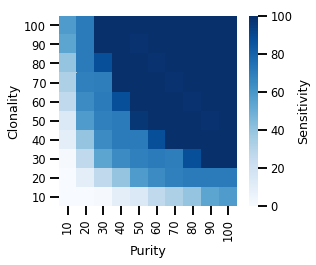

In [21]:
tmp_df = pd.DataFrame(artificial_purities_df.groupby('real_purity').Dash_Loss_Ext.mean()).reset_index()
tmp_df.columns = ['simulated_purity', 'Dash_Accuracy']

sns.set_context('talk', font_scale=0.7)
plt.figure(figsize=(4, 3.5))
accuracy_matrix = []
for clonality in clonalities[::-1]:
    accuracy_array = []
    for purity in purities:
        try:
            accuracy_array.append(list(tmp_df[tmp_df.simulated_purity == 
                                              int(clonality*purity / 100)].Dash_Accuracy)[0] * 100)
        except:
            accuracy_array.append(np.nan)
    accuracy_matrix.append(accuracy_array)

sns.heatmap(accuracy_matrix, xticklabels=purities, yticklabels=clonalities[::-1], cmap="Blues",
           vmin=0, vmax=100, cbar_kws={'label': 'Sensitivity'}) #, annot=True, fmt='g')
plt.xlabel('Purity')
plt.ylabel('Clonality')

plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/DASH.sensitivity.purity_clonality.heatmap.all_cell_lines.pdf',
           bbox_inches='tight')
print('/rnd/users/rpyke/data/00-DASH/figures/DASH.sensitivity.purity_clonality.heatmap.all_cell_lines.pdf')


In [22]:
accuracy_df = pd.DataFrame(accuracy_matrix)
accuracy_df.columns = ['Purity-{0}'.format(x) for x in purities]
accuracy_df.index = ['Clonality-{0}'.format(x) for x in clonalities[::-1]]

In [23]:
# Saving source data
panel_name = 'figure_2c'
accuracy_df.to_excel('/rnd/users/rpyke/data/00-DASH/manuscript_source_data/{0}.xlsx'.format(panel_name),
                                 index=None)

##### Specificity with full clonality

In [24]:
tmp_dfs = []
for cell_line in cell_lines:
    tmp_df = pd.read_csv('/rnd/users/rpyke/data/00-DASH/manuscript_data_v2/validation.cell_line_dash_output.{0}.csv'.format(cell_line),
                                         index_col=0)
    print(cell_line, list(tmp_df.columns))
    tmp_dfs.append(tmp_df)
    
artificial_purities_raw_df = pd.concat(tmp_dfs)


artificial_purities_raw_df['LOH'] = True
artificial_purities_raw_df['real_purity'] = artificial_purities_raw_df['Sample'].str.split('_p').str[1].str.split('_').str[0].astype(int)
artificial_purities_raw_df['cell_line'] = artificial_purities_raw_df['Sample'].str.split('_tumor').str[0]
artificial_purities_raw_df['replicate'] = artificial_purities_raw_df['Sample'].str.split('rep').str[1]

# Only looking at purity with 100% clonality
purities = list(artificial_purities_raw_df.real_purity.unique())
no_loh_df = artificial_purities_raw_df[artificial_purities_raw_df.real_purity == 0]
all_small_artificial_dfs = []
for purity in purities:
    actual_purity = purity
    if actual_purity == 1:
        continue
    tmp_df = artificial_purities_raw_df[artificial_purities_raw_df.real_purity == actual_purity]
    # Restricting to overlapping samples
    tmp_restricted_df = pd.merge(tmp_df, no_loh_df[['Gene', 'cell_line', 'replicate']], 
                 on=['Gene', 'cell_line', 'replicate'], how='inner')
    no_loh_restricted_df = pd.merge(tmp_df[['Gene', 'cell_line', 'replicate']], no_loh_df, 
                             on=['Gene', 'cell_line', 'replicate'], how='inner')
    #print(actual_purity, len(tmp_df), len(no_loh_restricted_df))
    
    sequenza_purity = artificial_purities_raw_df[artificial_purities_raw_df.real_purity == purity].Purity.mean()
    #print(actual_purity, sequenza_purity)
    tmp_restricted_df['adjusted_purity'] = sequenza_purity
    tmp_restricted_df['BAF'] = list(no_loh_restricted_df['BAF'])
    tmp_restricted_df['R1'] = list(no_loh_restricted_df['R1'])
    tmp_restricted_df['R2'] = list(no_loh_restricted_df['R2'])
    tmp_restricted_df['consistency_of_coverage'] = list(no_loh_restricted_df['consistency_of_coverage'])
    tmp_restricted_df['Sequenza_Loss'] = list(no_loh_restricted_df['Sequenza_Loss']) #True # Does this need to be updated? 
    all_small_artificial_dfs.append(tmp_restricted_df)

artificial_purities_df = pd.concat(all_small_artificial_dfs)
    

# Fixing purity
artificial_purities_df['old_purity'] = artificial_purities_df['Purity']
artificial_purities_df['purity'] = artificial_purities_df['adjusted_purity']

# Renaming other columns
artificial_purities_df['ploidy'] = artificial_purities_df['Ploidy']
artificial_purities_df['sequenza_minor'] = [0 if x == True else 1 for x in artificial_purities_df['Sequenza_Loss']]
artificial_purities_df['minMedCoverage'] = artificial_purities_df[['R1','R2']].min(axis=1)
artificial_purities_df['baf_median'] = artificial_purities_df['BAF']
artificial_purities_df['percCov'] = artificial_purities_df['consistency_of_coverage']
artificial_purities_df['totalCoverage_median'] = artificial_purities_df['total_coverage']
artificial_purities_df['Sequenza_Loss'] = ~artificial_purities_df['sequenza_minor'].astype(bool)


CRL-5922 ['Purity', 'R1', 'R2', 'BAF', 'Sequenza_Loss', 'Alternate_Loss', 'Dash_Loss', 'Ploidy', 'consistency_of_coverage', 'prediction_probability', 'secondary_check', 'total_coverage', 'Gene', 'Sample', 'ind']
CRL-5911 ['Purity', 'R1', 'R2', 'BAF', 'Sequenza_Loss', 'Alternate_Loss', 'Dash_Loss', 'Ploidy', 'consistency_of_coverage', 'prediction_probability', 'secondary_check', 'total_coverage', 'Gene', 'Sample', 'ind']
CRL-2314 ['Purity', 'R1', 'R2', 'BAF', 'Sequenza_Loss', 'Alternate_Loss', 'Dash_Loss', 'Ploidy', 'consistency_of_coverage', 'prediction_probability', 'secondary_check', 'total_coverage', 'Gene', 'Sample', 'ind']


In [25]:
artificial_purities_df[training_columns]

X_test = artificial_purities_df[training_columns]
y_test = artificial_purities_df[['LOH']]

predictions = model.predict(X_test) #predict_prob [:, 1]
prediction_probs = model.predict_proba(X_test)[:, 1]

In [26]:
artificial_purities_df['Check_FP'] = (artificial_purities_df.baf_median > BAF_cutoff) \
                                         &(artificial_purities_df.minMedCoverage < R_cutoff) #\
                                         #&(artificial_purities_df.sequenza_minor == 1)

In [27]:
lenient = []
for x, check in zip(prediction_probs, artificial_purities_df['Check_FP']):
    if (x > cutoff) and (check):
        lenient.append(0)
    else:
        lenient.append(1)
artificial_purities_df['Dash_Loss_Ext'] = lenient

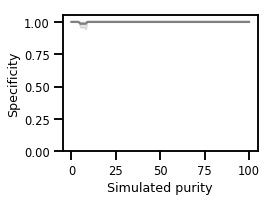

In [28]:
plt.figure(figsize=(3.5, 2.5))
sns.set_context('talk', font_scale=0.7)

sns.lineplot(x='real_purity', y='Dash_Loss_Ext', data=artificial_purities_df, color='grey')

plt.xlabel('Simulated purity')
plt.ylabel('Specificity')
plt.ylim(0, 1.05)
#plt.title('DASH')
plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/DASH.specificity.purity.line.all_cell_lines.pdf', bbox_inches='tight')

In [29]:
artificial_purities_df.groupby('real_purity')[['Dash_Loss_Ext']].mean().head(10)

,Dash_Loss_Ext
real_purity,
0,1.000000
2,1.000000
3,1.000000
4,1.000000
5,0.985714
6,0.985714
7,0.985714
8,0.985714
9,1.000000


In [30]:
artificial_purities_df[artificial_purities_df.Dash_Loss_Ext == 0][['cell_line', 'replicate', 'Gene', 'real_purity']]

,cell_line,replicate,Gene,real_purity
42,CRL-2314,3,C,8
51,CRL-2314,3,C,7
54,CRL-2314,3,C,6
69,CRL-2314,3,C,5


In [31]:
# Saving source data
panel_name = 'supp_figure_9b'
artificial_purities_df[artificial_purities_df.real_purity != 0][['real_purity', 'Dash_Loss_Ext', 'LOH']].sort_values('real_purity').to_excel('/rnd/users/rpyke/data/00-DASH/manuscript_source_data/{0}.xlsx'.format(panel_name),
                                 index=None)

##### Specificity across variable clonalities

In [32]:
all_small_artificial_dfs = []
purities = list(range(10, 110, 10))
clonalities = list(range(10, 110, 10))
no_loh_df = artificial_purities_raw_df[artificial_purities_raw_df.real_purity == 0]
for purity in purities:
    for clonality in clonalities:
        actual_purity = round(int(purity*clonality)/100)
        if actual_purity == 1:
            continue
        tmp_df = artificial_purities_raw_df[artificial_purities_raw_df.real_purity == actual_purity]
        # Restricting to overlapping samples
        tmp_restricted_df = pd.merge(tmp_df, no_loh_df[['Gene', 'cell_line', 'replicate']], 
                     on=['Gene', 'cell_line', 'replicate'], how='inner')
        no_loh_restricted_df = pd.merge(tmp_df[['Gene', 'cell_line', 'replicate']], no_loh_df, 
                                 on=['Gene', 'cell_line', 'replicate'], how='inner')

        sequenza_purity = artificial_purities_raw_df[artificial_purities_raw_df.real_purity == purity].Purity.mean()
        tmp_restricted_df['adjusted_purity'] = sequenza_purity
        sequenza_ploidy = artificial_purities_raw_df[artificial_purities_raw_df.real_purity == purity].Ploidy.mean()
        tmp_restricted_df['adjusted_ploidy'] = sequenza_ploidy
        
        tmp_restricted_df['BAF'] = list(no_loh_restricted_df['BAF'])
        tmp_restricted_df['R1'] = list(no_loh_restricted_df['R1'])
        tmp_restricted_df['R2'] = list(no_loh_restricted_df['R2'])
        tmp_restricted_df['consistency_of_coverage'] = list(no_loh_restricted_df['consistency_of_coverage'])
        tmp_restricted_df['Sequenza_Loss'] = list(no_loh_restricted_df['Sequenza_Loss'])  
        all_small_artificial_dfs.append(tmp_restricted_df)

artificial_purities_df = pd.concat(all_small_artificial_dfs)
    

# Fixing purity/ploidy
artificial_purities_df['old_purity'] = artificial_purities_df['Purity']
artificial_purities_df['purity'] = artificial_purities_df['adjusted_purity']
artificial_purities_df['old_ploidy'] = artificial_purities_df['Ploidy']
artificial_purities_df['ploidy'] = artificial_purities_df['adjusted_ploidy']

# Renaming other columns
artificial_purities_df['sequenza_minor'] = [0 if x == True else 1 for x in artificial_purities_df['Sequenza_Loss']]
artificial_purities_df['minMedCoverage'] = artificial_purities_df[['R1','R2']].min(axis=1)
artificial_purities_df['baf_median'] = artificial_purities_df['BAF']
artificial_purities_df['percCov'] = artificial_purities_df['consistency_of_coverage']
artificial_purities_df['totalCoverage_median'] = artificial_purities_df['total_coverage']
artificial_purities_df['Sequenza_Loss'] = ~artificial_purities_df['sequenza_minor'].astype(bool)

In [33]:
X_test = artificial_purities_df[training_columns]
y_test = artificial_purities_df[['LOH']]

predictions = model.predict(X_test) #predict_prob [:, 1]
prediction_probs = model.predict_proba(X_test)[:, 1]

In [34]:
# Adding secondary check
artificial_purities_df['Check_FP'] = (artificial_purities_df.baf_median > BAF_cutoff) \
                                         &(artificial_purities_df.minMedCoverage < R_cutoff) #\
                                         #&(artificial_purities_df.sequenza_minor == 1)

In [35]:
lenient = []
for x, check in zip(prediction_probs, artificial_purities_df['Check_FP']):
    if (x > cutoff) and (check):
        lenient.append(1)
    else:
        lenient.append(0)
artificial_purities_df['Dash_Loss_Ext'] = lenient

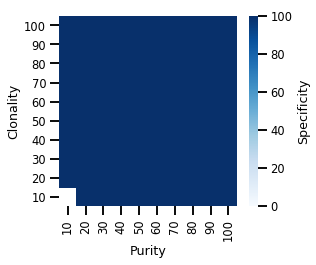

In [36]:
tmp_df = pd.DataFrame(artificial_purities_df.groupby('real_purity').Dash_Loss_Ext.mean()).reset_index()
tmp_df.columns = ['simulated_purity', 'Dash_Accuracy']
tmp_df['DASH_Specificity'] = 1 - tmp_df.Dash_Accuracy # Inverted for specificity (these are negatives)

sns.set_context('talk', font_scale=0.7)
plt.figure(figsize=(4, 3.5))
accuracy_matrix = []
for purity in purities[::-1]:
    accuracy_array = []
    for clonality in clonalities:
        try:
            accuracy_array.append(list(tmp_df[tmp_df.simulated_purity == 
                                              int(clonality*purity / 100)].DASH_Specificity)[0] * 100)
        except:
            accuracy_array.append(np.nan)
    accuracy_matrix.append(accuracy_array)

sns.heatmap(accuracy_matrix, xticklabels=purities, yticklabels=clonalities[::-1], cmap="Blues",
           vmin=0, vmax=100, cbar_kws={'label': 'Specificity'}) #, annot=True, fmt='g')
plt.xlabel('Purity')
plt.ylabel('Clonality')
#plt.title('Updated Algorithm')
plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/DASH.specificity.purity_clonality.heatmap.lenient.blues_r.all_cell_lines.pdf',
           bbox_inches='tight')

In [37]:
accuracy_matrix

[[100, 100, 100, 100, 100, 100, 100, 100, 100, 100],
 [100, 100, 100, 100, 100, 100, 100, 100, 100, 100],
 [100, 100, 100, 100, 100, 100, 100, 100, 100, 100],
 [100, 100, 100, 100, 100, 100, 100, 100, 100, 100],
 [100, 100, 100, 100, 100, 100, 100, 100, 100, 100],
 [100, 100, 100, 100, 100, 100, 100, 100, 100, 100],
 [100, 100, 100, 100, 100, 100, 100, 100, 100, 100],
 [100, 100, 100, 100, 100, 100, 100, 100, 100, 100],
 [100, 100, 100, 100, 100, 100, 100, 100, 100, 100],
 [nan, 100, 100, 100, 100, 100, 100, 100, 100, 100]]

In [38]:
accuracy_df = pd.DataFrame(accuracy_matrix)
accuracy_df.columns = ['Purity-{0}'.format(x) for x in purities]
accuracy_df.index = ['Clonality-{0}'.format(x) for x in clonalities[::-1]]

In [39]:
# Saving source data
panel_name = 'figure_2b'
accuracy_df.to_excel('/rnd/users/rpyke/data/00-DASH/manuscript_source_data/{0}.xlsx'.format(panel_name),
                                 index=None)